<a href="https://colab.research.google.com/github/hnidey13/tesis_SVD_t-SVDM/blob/main/ejemplo_StarPlus_fMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Clasificación con t-SVDM (DFT)**

Realizamos la conexión, cambiamos directorio de trabajo y cargamos librerías

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
os.chdir('/content/gdrive/MyDrive/tensor-fmri')

import numpy as np
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots, classification_plots
import matplotlib.pyplot as plt
import similarity_metrics as sm
import scipy.io
import utils.starplus_utils as starp
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
import pickle

Mounted at /content/gdrive


Parámetros iniciales

In [ ]:
save = True
filename = 'local_tsvd'
plot = True
prod_type = 't'

Definimos proyección

In [ ]:
def projection(A, U, prod_type, M=None, dim_list=()):
    training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type, M=M, dim_list=dim_list)
    return tp.ten_prod(U, training_coeff, prod_type=prod_type, M=M, dim_list=dim_list)

Leemos datos de un individuo y separamos en train y test

In [ ]:
np.random.seed(20)

#Lectura de datos
star_plus_data = scipy.io.loadmat('/content/gdrive/MyDrive/Colab (datos)/StarPlus fMRI data/data-starplus-04799-v7.mat')
tensor_PS, labels = starp.get_labels(star_plus_data)
tensor_PS = tensor_PS / norm(tensor_PS)

#Train y test
training_data, test_data, training_labels, test_labels = train_test_split(np.moveaxis(tensor_PS, -1, 0), labels,
                                                                          test_size=0.33, random_state=42)
training_data = np.moveaxis(training_data, 0, 1)
test_data = np.moveaxis(test_data, 0, 1)


Estructura

In [ ]:
print(tensor_PS.shape)
print(labels.shape)
print(np.count_nonzero(labels == 0))
print(np.count_nonzero(labels == 1))
print(np.moveaxis(tensor_PS, -1, 0).shape)
print(training_data.shape)
print(test_data.shape)

(64, 64, 8, 16, 80)
(80,)
40
40
(80, 64, 64, 8, 16)
(64, 53, 64, 8, 16)
(64, 27, 64, 8, 16)


Calculamos t-SVDM de rango $k$

In [ ]:
num_classes = len(np.unique(training_labels))
range_k = range(2,16)

U = []

for i in range(num_classes):
    u, _, _, _ = tp.ten_svd(training_data[:, training_labels == i], k=max(range_k), prod_type=prod_type)
    U.append(u)

Clasificamos para entrenamiento y prueba

In [ ]:
training_error = np.zeros([num_classes, training_data.shape[1], len(range_k)])
test_error = np.zeros([num_classes, test_data.shape[1], len(range_k)])
for j, k in enumerate(range_k):
    for i in range(num_classes):
        training_projection = projection(training_data, U[i][:, :k], prod_type=prod_type)
        training_error[i, :, j] = sm.frobenius_metric(training_data, training_projection, axis=1)

        test_projection = projection(test_data, U[i][:, :k], prod_type=prod_type)
        test_error[i, :, j] = sm.frobenius_metric(test_data, test_projection, axis=1)


#Clasificación
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1, len(range_k))
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1, len(range_k))

Resultados

k = 2: train accuracy = 100.00	test accuracy = 66.67
k = 3: train accuracy = 100.00	test accuracy = 62.96
k = 4: train accuracy = 100.00	test accuracy = 66.67
k = 5: train accuracy = 100.00	test accuracy = 66.67
k = 6: train accuracy = 100.00	test accuracy = 66.67
k = 7: train accuracy = 100.00	test accuracy = 66.67
k = 8: train accuracy = 100.00	test accuracy = 74.07
k = 9: train accuracy = 100.00	test accuracy = 70.37
k = 10: train accuracy = 100.00	test accuracy = 70.37
k = 11: train accuracy = 100.00	test accuracy = 70.37
k = 12: train accuracy = 100.00	test accuracy = 70.37
k = 13: train accuracy = 100.00	test accuracy = 66.67
k = 14: train accuracy = 100.00	test accuracy = 66.67
k = 15: train accuracy = 100.00	test accuracy = 66.67


<Figure size 432x288 with 0 Axes>

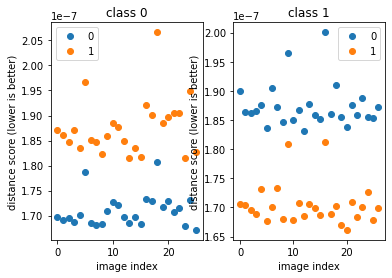

In [ ]:
training_num_correct = np.sum(training_predicted_classes == training_labels.reshape(-1, 1), axis=0)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == test_labels.reshape(-1, 1), axis=0)
test_accuracy = test_num_correct / test_data.shape[1]
test_acc_tSVDM = test_accuracy

for j, k in enumerate(range_k):
    print('k = %d: train accuracy = %0.2f\ttest accuracy = %0.2f' %
          (k, 100 * training_accuracy[j], 100 * test_accuracy[j]))

if save:
    if not os.path.exists('results/'):
        os.makedirs('results/')
    stored_results = {'training_error' : training_error,
                      'test_error' : test_error,
                      'training_accuracy' : training_accuracy,
                      'test_accuracy' : test_accuracy}
    pickle.dump(stored_results, open('results/' + filename + '-' + prod_type + '.py', 'wb'))

#Gráfica
if plot:
    plt.figure()
    classification_plots(training_error[:, :, 0], training_labels)
    plt.show()

### **Clasificación con SVD Matricial**

Librerías necesarias

In [ ]:
from tensor.utils import reshape
from numpy.linalg import svd

Parámetros

In [ ]:
filename = 'local_svd'

Definimos proyección

In [ ]:
def projection(A, U):
    training_coeff = U.T @ A
    return U @ training_coeff

Vectorizamos y dividimos en train y test

In [ ]:
# vectorize
tensor_PS = np.moveaxis(tensor_PS, -1, 0)
tensor_PS = reshape(tensor_PS, [tensor_PS.shape[0], -1])
tensor_PS = tensor_PS.T

# split
training_data, test_data, training_labels, test_labels = train_test_split(np.moveaxis(tensor_PS, -1, 0), labels,
                                                                          test_size=0.33, random_state=42)
training_data = np.moveaxis(training_data, 0, 1)
test_data = np.moveaxis(test_data, 0, 1)

Calculamos SVD de rango $k$

In [ ]:
num_classes = len(np.unique(training_labels))

U = []
for i in range(num_classes):
    u, _, _ = svd(training_data[:, training_labels == i], full_matrices=False)
    U.append(u[:, :max(range_k)])

Clasificamos para entrenamiento y prueba

In [ ]:
training_error = np.zeros([num_classes, training_data.shape[1], len(range_k)])
test_error = np.zeros([num_classes, test_data.shape[1], len(range_k)])

for j, k in enumerate(range_k):
    for i in range(num_classes):
        training_projection = projection(training_data, U[i][:, :k])
        training_error[i, :, j] = sm.frobenius_metric(training_data, training_projection, axis=1)

        test_projection = projection(test_data, U[i][:, :k])
        test_error[i, :, j] = sm.frobenius_metric(test_data, test_projection, axis=1)

training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1, len(range_k))
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1, len(range_k))

Resultados

k = 2: train accuracy = 94.34	test accuracy = 59.26
k = 3: train accuracy = 100.00	test accuracy = 62.96
k = 4: train accuracy = 100.00	test accuracy = 62.96
k = 5: train accuracy = 100.00	test accuracy = 55.56
k = 6: train accuracy = 100.00	test accuracy = 55.56
k = 7: train accuracy = 100.00	test accuracy = 55.56
k = 8: train accuracy = 100.00	test accuracy = 59.26
k = 9: train accuracy = 100.00	test accuracy = 62.96
k = 10: train accuracy = 100.00	test accuracy = 59.26
k = 11: train accuracy = 100.00	test accuracy = 59.26
k = 12: train accuracy = 100.00	test accuracy = 55.56
k = 13: train accuracy = 100.00	test accuracy = 59.26
k = 14: train accuracy = 100.00	test accuracy = 59.26
k = 15: train accuracy = 100.00	test accuracy = 59.26


<Figure size 432x288 with 0 Axes>

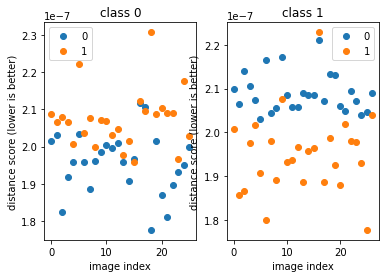

In [ ]:
training_num_correct = np.sum(training_predicted_classes == training_labels.reshape(-1, 1), axis=0)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == test_labels.reshape(-1, 1), axis=0)
test_accuracy = test_num_correct / test_data.shape[1]
test_acc_SVD = test_accuracy

for j, k in enumerate(range_k):
    print('k = %d: train accuracy = %0.2f\ttest accuracy = %0.2f' %
          (k, 100 * training_accuracy[j], 100 * test_accuracy[j]))

if save:
    if not os.path.exists('results/'):
        os.makedirs('results/')
    stored_results = {'training_error' : training_error,
                      'test_error' : test_error,
                      'training_accuracy' : training_accuracy,
                      'test_accuracy' : test_accuracy}
    pickle.dump(stored_results, open('results/' + filename + '.py', 'wb'))

if plot:
    plt.figure()
    classification_plots(training_error[:, :, 0], training_labels)
    plt.show()

Comparación de resultados

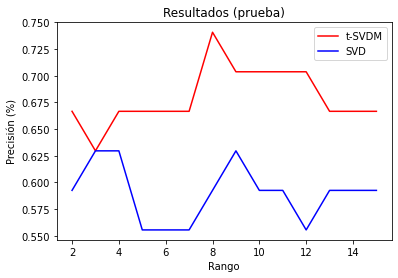

In [ ]:
plt.figure()
plt.plot(range_k, test_acc_tSVDM, label='t-SVDM', color = 'red')
plt.plot(range_k, test_acc_SVD, label='SVD', color = 'blue')
plt.title('Resultados (prueba)')
plt.xlabel('Rango')
plt.ylabel('Precisión (%)')
plt.legend()
plt.show()